## Test Model Training
change some constants and train model using data from supabase.

In [105]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import os
import sys
from dotenv import load_dotenv
from supabase import create_client, Client
from datetime import datetime, timedelta

# Load .env file
load_dotenv()

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../lib")))

In [106]:
# Get environment variables
SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_SERVICE_ROLE_KEY = os.getenv("SUPABASE_SECRET_KEY")
DATE_START = "2025-08-25"
DATE_END = "2025-08-29"
GARAGE = "South Garage"
ESTIMATORS = 500

# Initialize client
supabase: Client = create_client(SUPABASE_URL, SUPABASE_SERVICE_ROLE_KEY)

def load_data_from_supabase(table):
    # Convert DATE_START and DATE_END to datetime objects
    date_start_dt = datetime.strptime(DATE_START, "%Y-%m-%d")
    date_end_dt = datetime.strptime(DATE_END, "%Y-%m-%d")

    # Fetch all rows from supabase
    response = supabase.table(table).select("*").eq("garage", GARAGE).execute()
    data = response.data

    # Filter rows based on timestamp string
    filtered_data = []
    for row in data:
        # Parse timestamp string, e.g., "2025-8-20 7:25:00 PM"
        ts = datetime.strptime(row["timestamp"], "%Y-%m-%d %I:%M:%S %p")
        if date_start_dt <= ts <= date_end_dt:
            filtered_data.append(row)
    return filtered_data

raw_data = load_data_from_supabase("random_forest_predictions")

In [107]:
def get_minutes_from_week_start(timestamp: datetime) -> float:
    """
    Convert a timestamp to minutes from the start of the week (Monday 12 AM)
    """
    if isinstance(timestamp, str):
        # Handle format like "2025-8-21 7:13:00 PM"
        timestamp = datetime.strptime(timestamp, "%Y-%m-%d %I:%M:%S %p")
    
    week_start = timestamp.replace(hour=0, minute=0, second=0, microsecond=0)
    week_start = week_start - timedelta(days=timestamp.weekday())
    minutes_diff = (timestamp - week_start).total_seconds() / 60
    return minutes_diff 

# convert raw supabase data into x and y arrays for random forest regression
def convert_x_y(data):
    X = []
    Y = []

    for i in data:
        X.append(get_minutes_from_week_start(i["timestamp"]))
        Y.append(i["fullness"])

    return X, Y

X, Y = convert_x_y(raw_data)

In [108]:
# train model
model = RandomForestRegressor(n_estimators=ESTIMATORS)
X = np.array(X).reshape(-1, 1)
model.fit(X, Y)

,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [109]:
# inference on one point using model
model.predict([[get_minutes_from_week_start("2025-8-26 9:00:00 AM")]])

array([83.718])

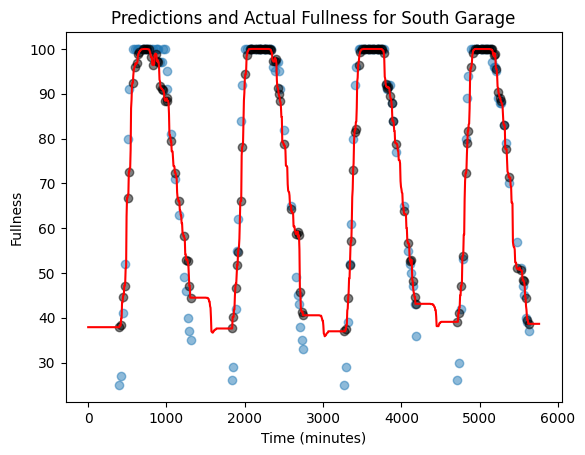

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

# plot
def make_plot(x_data, y_data, model):
    # generate x_stream from start of monday to end of thursday
    x_end = pd.Timedelta(days=4).total_seconds() / 60
    all_x_vals = np.linspace(0, x_end, num=1000)
    
    plt.scatter(x_data, y_data, alpha=0.5)
    plt.scatter(x_data, model(x_data), color='black', alpha=0.5)


    # plt.scatter(x_data, y_data, color='blue', alpha=0.5, label='raw data')
    # plt.scatter(x_data, model(pd.Series(x_data), *model_weights), color='orange', alpha=0.5, label='model values')
    plt.plot(all_x_vals, model(all_x_vals.reshape(-1, 1)), color='red')
    
    plt.xlabel('Time (minutes)')
    plt.ylabel('Fullness')
    plt.title(f'Predictions and Actual Fullness for {GARAGE}')
    # plt.savefig(FIG_OUT_PATH + f"{current_time_str}_{garage}_{start_dates[0].strftime('%Y-%m-%d')}_plot.png", bbox_inches="tight")
    plt.show()


# get actual data
raw_actual_data = load_data_from_supabase("real_data")
real_x, real_y = convert_x_y(raw_actual_data)
real_x = np.array(real_x).reshape(-1, 1)


make_plot(real_x, real_y, model.predict)